In [1]:
import pandas as pd
import numpy as np
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from collections import Counter

## Load the dataset

In [2]:
# Load the transfer dataset
transfer_df = pd.read_csv("../../TransfersWithStats.csv")\
                .drop("Unnamed: 0", axis=1)
transfer_df.shape

(4891, 48)

In [3]:
# Load the bucket dataset
bucket_df = pd.read_csv("../../Corrected_School_List_Buckets.csv")\
            [["TeamName",'Definitive Bucket']]
len(bucket_df) # number of Div. I schools

361

## Bucket Functions

In [4]:
# Define a function that gets the rating of a program
def get_bucket(school):
    if school in bucket_df.TeamName.values:
        return bucket_df[bucket_df.TeamName == school]\
                        ["Definitive Bucket"].values[0]
    else:
        return 0
print(get_bucket("San Francisco")) # test a Div.I program
print(get_bucket("BYU-Hawaii")) # test a non-Div.I program

5
0


In [5]:
# Define a function that puts 1-9 scale into 3 wide buckets
def getWideBucket(num):
    if num < 4:
        return "Low-Majors"
    elif num < 7:
        return "Mid-Majors"
    else:
        return "High-Majors"

print(getWideBucket(9))

High-Majors


## Data-Preprocessing

In [6]:
# Filter out bad match
transfer_df_adj = transfer_df[(transfer_df.Team == \
                               transfer_df.new_school_alias_match_pl) |
                              (transfer_df.Team == \
                               transfer_df.prev_school_alias_match_pl)]
print(transfer_df.shape[0], transfer_df_adj.shape[0])

4891 4569


In [7]:
# Get bucket for each row
transfer_df_adj2 = transfer_df[transfer_df.Player != 'Anthony Horton']
transfer_df_adj2["prev_school_bucket"] = transfer_df_adj2.prev_school\
                                                         .apply(lambda x: x.replace('UNCG', 'UNC Greensboro'))\
                                                         .apply(get_bucket)
transfer_df_adj2["new_school_bucket"] = transfer_df_adj2.new_school\
                                                        .apply(lambda x: x.replace('UNCG', 'UNC Greensboro'))\
                                                        .apply(get_bucket)

/Users/xulian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/xulian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
# Take out players that show up for only one row
print(transfer_df_adj2.shape)
transfer_season_cnt = Counter(transfer_df_adj2.Player)
single_season_player_list = []
for player in list(set(transfer_df_adj2.Player)):
    if transfer_season_cnt[player] < 2:
        single_season_player_list.append(player)
print(len(single_season_player_list))
transfer_df_adj3 = transfer_df_adj2[~transfer_df_adj2.Player.isin(single_season_player_list)]
print(transfer_df_adj3.shape)

(4886, 50)
128
(4758, 50)


In [9]:
# Filter out the 2018 record
transfer_df_adj4 = transfer_df_adj3[transfer_df_adj3.tr_yr != 2018]
transfer_df_adj4.shape

(4127, 50)

In [10]:
# Number of new school player should be the same as 
# that of old school player
transfer_df_new_skl = transfer_df_adj4[transfer_df_adj4.Team == \
                                       transfer_df_adj4.new_school_alias_match_pl]
transfer_df_old_skl = transfer_df_adj4[transfer_df_adj4.Team == \
                                       transfer_df_adj4.prev_school_alias_match_pl]
print(len(set(transfer_df_new_skl)))
print(len(set(transfer_df_old_skl)))
diff1 = list(set(transfer_df_new_skl.Player) - set(transfer_df_old_skl.Player))
diff2 = list(set(transfer_df_old_skl.Player) - set(transfer_df_new_skl.Player))
transfer_df_adj5 = transfer_df_adj4[~transfer_df_adj4.Player.isin(diff1)]
transfer_df_adj6 =transfer_df_adj5[~transfer_df_adj4.Player.isin(diff2)]
print(len(set(transfer_df_adj6[transfer_df_adj6.Team == \
                               transfer_df_adj6.new_school_alias_match_pl].Player)))
print(len(set(transfer_df_adj6[transfer_df_adj6.Team == \
                               transfer_df_adj6.prev_school_alias_match_pl].Player)))

50
50
1084
1084


/Users/xulian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [11]:
# Investigate graduate transfer
imm_eligible_transfer_df = transfer_df_adj6[transfer_df_adj6.imm_eligible == 1]
imm_eligible_transfer_new_skl = imm_eligible_transfer_df[imm_eligible_transfer_df.Team == \
                                                         imm_eligible_transfer_df.new_school_alias_match_pl]
anomaly_player_list = []
for player in Counter(imm_eligible_transfer_new_skl.Player):
    if Counter(imm_eligible_transfer_new_skl.Player)[player] > 1:
        anomaly_player_list.append(player)
        
# Adjust
transfer_df_adj6[transfer_df_adj6.Player.isin(anomaly_player_list)].index

Int64Index([  49,   50,   51,  348,  349,  350,  351,  352,  353,  365,
            ...
            4760, 4761, 4762, 4807, 4808, 4809, 4810, 4874, 4875, 4876],
           dtype='int64', length=165)

In [12]:
# adjust the false 'graduate transfers' back to 'sit-out transfers'
for idx in transfer_df_adj6[transfer_df_adj6.Player.isin(anomaly_player_list)].index:
    transfer_df_adj6.loc[idx, 'imm_eligible'] = 0

/Users/xulian/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
# Test if there is an anomaly again
imm_eligible_transfer_df = transfer_df_adj6[transfer_df_adj6.imm_eligible == 1]
imm_eligible_transfer_new_skl = imm_eligible_transfer_df[imm_eligible_transfer_df.Team == \
                                                         imm_eligible_transfer_df.new_school_alias_match_pl]
for player in Counter(imm_eligible_transfer_new_skl.Player):
    if Counter(imm_eligible_transfer_new_skl.Player)[player] > 1:
        print(player)

In [14]:
# Create two different dataframes
# One for graudate transfers
# One for sit-out transfers
graduate_transfer_df = transfer_df_adj6[transfer_df_adj6.imm_eligible == 1]
sit_out_transfer_df = transfer_df_adj6[transfer_df_adj6.imm_eligible == 0]

In [15]:
graduate_transfer_list = list(set(graduate_transfer_df.Player))
print(f"Number of graduate transfers: {len(graduate_transfer_list)}")
sit_out_transfer_list = list(set(sit_out_transfer_df.Player))
print(f"Number of sit out transfers: {len(sit_out_transfer_list)}")

Number of graduate transfers: 268
Number of sit out transfers: 826


In [16]:
# Get last pre-transfer season BPM for graduate transfers
graduate_transfer_df_list = []
for player in graduate_transfer_list:
    temp_df = graduate_transfer_df[graduate_transfer_df.Player == player]
    temp_df_adj = temp_df[temp_df.Team == temp_df.prev_school_alias_match_pl]
    temp_df_adj2 = temp_df_adj[temp_df.Season == temp_df_adj.Season.max()]
    graduate_transfer_df_list.append(temp_df_adj2)
graduate_transfer_last_season_df = pd.concat(graduate_transfer_df_list)
graduate_transfer_last_season_df["prev_school_wide_bucket"] = graduate_transfer_last_season_df.prev_school_bucket\
                                                                                            .apply(lambda x: getWideBucket(x))
graduate_transfer_last_season_df["new_school_wide_bucket"] = graduate_transfer_last_season_df.new_school_bucket\
                                                                                            .apply(lambda x: getWideBucket(x))
graduate_transfer_last_season_df.shape

/Users/xulian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(266, 52)

In [17]:
# Get last pre-transfer season BPM for sit out transfers
sit_out_transfer_df_list = []
for player in sit_out_transfer_list:
    temp_df = sit_out_transfer_df[sit_out_transfer_df.Player == player]
    temp_df_adj = temp_df[temp_df.Team == temp_df.prev_school_alias_match_pl]
    temp_df_adj2 = temp_df_adj[temp_df.Season == temp_df_adj.Season.max()]
    sit_out_transfer_df_list.append(temp_df_adj2)
sit_out_transfer_last_season_df = pd.concat(sit_out_transfer_df_list)
sit_out_transfer_last_season_df["prev_school_wide_bucket"] = sit_out_transfer_last_season_df.prev_school_bucket\
                                                                                            .apply(lambda x: getWideBucket(x))
sit_out_transfer_last_season_df["new_school_wide_bucket"] = sit_out_transfer_last_season_df.new_school_bucket\
                                                                                            .apply(lambda x: getWideBucket(x))

sit_out_transfer_last_season_df.shape

/Users/xulian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(822, 52)

In [18]:
# Merge graduate transfers and sit out transfers into one dataframe
graduate_transfer_last_season_df_adj = graduate_transfer_last_season_df[["Team", "Player", "MP", "BPM", "Season",
                                                                         "prev_school", "new_school", 
                                                                         "prev_school_wide_bucket", 
                                                                         "new_school_wide_bucket"]]
graduate_transfer_last_season_df_adj["Type"] = "graduate"
sit_out_transfer_last_season_df_adj = sit_out_transfer_last_season_df[["Team", "Player", "MP", "BPM", "Season",
                                                                       "prev_school", "new_school", 
                                                                       "prev_school_wide_bucket", 
                                                                       "new_school_wide_bucket"]]
sit_out_transfer_last_season_df_adj["Type"] = "sit out"
transfer_last_season_df = pd.concat([graduate_transfer_last_season_df_adj,
                                     sit_out_transfer_last_season_df_adj])
transfer_last_season_df.shape

/Users/xulian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/xulian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


(1088, 10)

In [19]:
# Get transfers who 'transferred up'
# Below are the Scenarios
# High -> High
# Mid -> High
# Mid -> Mid
# Low -> High
# Low -> Mid

transfer_last_season_df_adj1 = transfer_last_season_df[transfer_last_season_df.new_school_wide_bucket \
                                                       == 'High-Majors']
transfer_last_season_df_adj2 = transfer_last_season_df[(transfer_last_season_df.new_school_wide_bucket \
                                                        == 'Mid-Majors') &
                                                       (transfer_last_season_df.prev_school_wide_bucket \
                                                        != 'High-Majors')]
transfer_last_season_df_adj = pd.concat([transfer_last_season_df_adj1, transfer_last_season_df_adj2])
transfer_last_season_df_adj = transfer_last_season_df_adj[transfer_last_season_df_adj.MP > 100]
transfer_last_season_df_adj.shape

(454, 10)

## Data Visualization

By using matplotlib, below is the histogram.

Text(0.5, 1.0, "Histogram of 'Transfer Up' Players' BPM \nin Their Last Pre-Transfer Season\n(2012-2017)")

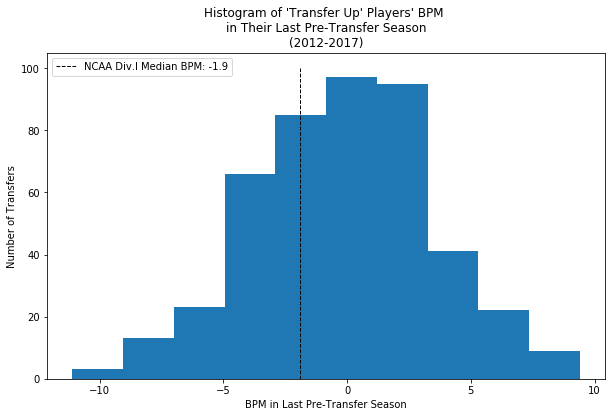

In [20]:
figsize(10,6)
plt.hist(transfer_last_season_df_adj.BPM)
plt.plot([-1.9, -1.9], [0, 100], '--', lw=1, 
         color = 'black', label = "NCAA Div.I Median BPM: -1.9")
plt.xlabel('BPM in Last Pre-Transfer Season')
plt.ylabel('Number of Transfers')
plt.legend(loc='upper left')
plt.title("Histogram of 'Transfer Up' Players' BPM \nin Their Last Pre-Transfer Season\n(2012-2017)")

The overall distribution of the 'Transfer Up' players' last pre-transfer season's BPM is approximately normal, with the mode being higher than the Div.I median (-1.9) from 2012-2017.  

It is noticeable that some of the 'Transfer Up' players have terrible BPM. So, it is necessary to further investigate these mediorce samples, especially the ones who transferred up to the High-Majors.

In [21]:
high_major_transfer_up_df = transfer_last_season_df_adj[transfer_last_season_df_adj.new_school_wide_bucket == 'High-Majors']
high_major_transfer_up_df.sort_values('BPM').head(4)

,Team,Player,MP,BPM,Season,prev_school,new_school,prev_school_wide_bucket,new_school_wide_bucket,Type
462,robert-morris,Braden Burke,487.0,-9.4,2017,Robert Morris,Michigan State,Low-Majors,High-Majors,sit out
696,lipscomb,Carter Sanderson,360.0,-8.6,2014,Lipscomb,Syracuse,Low-Majors,High-Majors,graduate
3056,chicago-state,Kurt Karis,294.0,-8.4,2015,Chicago State,USC,Low-Majors,High-Majors,sit out
2345,houston-baptist,Jimmy Barton,516.0,-8.4,2014,Houston Baptist,Missouri,Low-Majors,High-Majors,sit out


After sorting the BPM, it seems there are a few players who transferred up to High-Majors with terrible BPM are actually walk-ons. Therefore, for further analysis, these walk-ons have to be filtered out.